# **MRzero: MRI Basic Physics**

In this notebook, MRzero simulation is used to simulate FID and Spin Echo signal acquisition. The sequence files are created with pypulseq.

**1. Install and import libraries**

In [66]:
!pip install pypulseq==1.4.2 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [67]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
import os
from google.colab import output

plt.rcParams['figure.dpi'] = 100

**2. Prepare scanner**

In [68]:
system = pp.Opts(
    max_grad=80,
    grad_unit='mT/m',
    max_slew=200,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    adc_dead_time=20e-6,
    grad_raster_time=10e-6
)

**3. Acquisition conditions**

In [69]:
fov, slice_thickness = 200e-3, 8e-3#m
Nread, Nphase = 64, 64

**4. Construct sequence with pypulseq and save**

In [70]:
def aux_check_timing(seq):
  (ok,error_report,) = seq.check_timing()
  if ok:
      print("Timing check passed successfully")
  else:
      print("Timing check failed. Error listing follows:")
      [print(e) for e in error_report]

In [71]:
# Define rf event
rf_duration = 1e-3
rf1, gz, gzr = pp.make_sinc_pulse(
    flip_angle = 90*np.pi/180, # degrees
    duration = rf_duration, # s
    slice_thickness = slice_thickness,
    apodization = 0.5,
    time_bw_product = 4,
    system = system,
    return_gz = True
)

rfinv, gzinv, gzrinv = pp.make_sinc_pulse(
    flip_angle = 180*np.pi/180, # degrees
    duration = rf_duration, # s
    slice_thickness = slice_thickness,
    apodization = 0.5,
    time_bw_product = 4,
    system = system,
    return_gz = True
)


# Define ADC readout
adc_FID_duration_OG = 30e-3
adc_SE_duration_OG = 8e-3

# Formatting them according to adc raster time
adc_FID_duration = ((adc_FID_duration_OG/Nread) // system.grad_raster_time) * Nread * system.grad_raster_time
adc_SE_duration = ((adc_SE_duration_OG/Nread) // system.grad_raster_time) * Nread * system.grad_raster_time

adc_FID = pp.make_adc(num_samples=Nread, duration = adc_FID_duration)
adc_SE = pp.make_adc(num_samples=Nread, duration = adc_SE_duration)

# Delay
SE_delay_time = 4e-3
SE_delay = pp.make_delay(SE_delay_time)

# Build sequences

# T2star relaxation
seqT2star = pp.Sequence()
seqT2star.add_block(rf1, gz)
seqT2star.add_block(gzr)
seqT2star.add_block(adc_FID)
aux_check_timing(seqT2star)
seqT2star.write("FID.seq")

# Spin echo
seqSE = pp.Sequence()
seqSE.add_block(rf1)
seqSE.add_block(SE_delay)
seqSE.add_block(rfinv)
seqSE.add_block(pp.make_delay(SE_delay_time + rf_duration / 2. - adc_SE_duration / 2.))
seqSE.add_block(adc_SE)
seqSE.add_block(pp.make_delay(3*(SE_delay_time + rf_duration / 2. - adc_SE_duration / 2.)))
aux_check_timing(seqSE)
seqSE.write("SpinEcho.seq")

Timing check passed successfully
Timing check passed successfully


'ab3454d3c08df0fd785e595b14cce203'

**5. Prepare digital phantom**

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


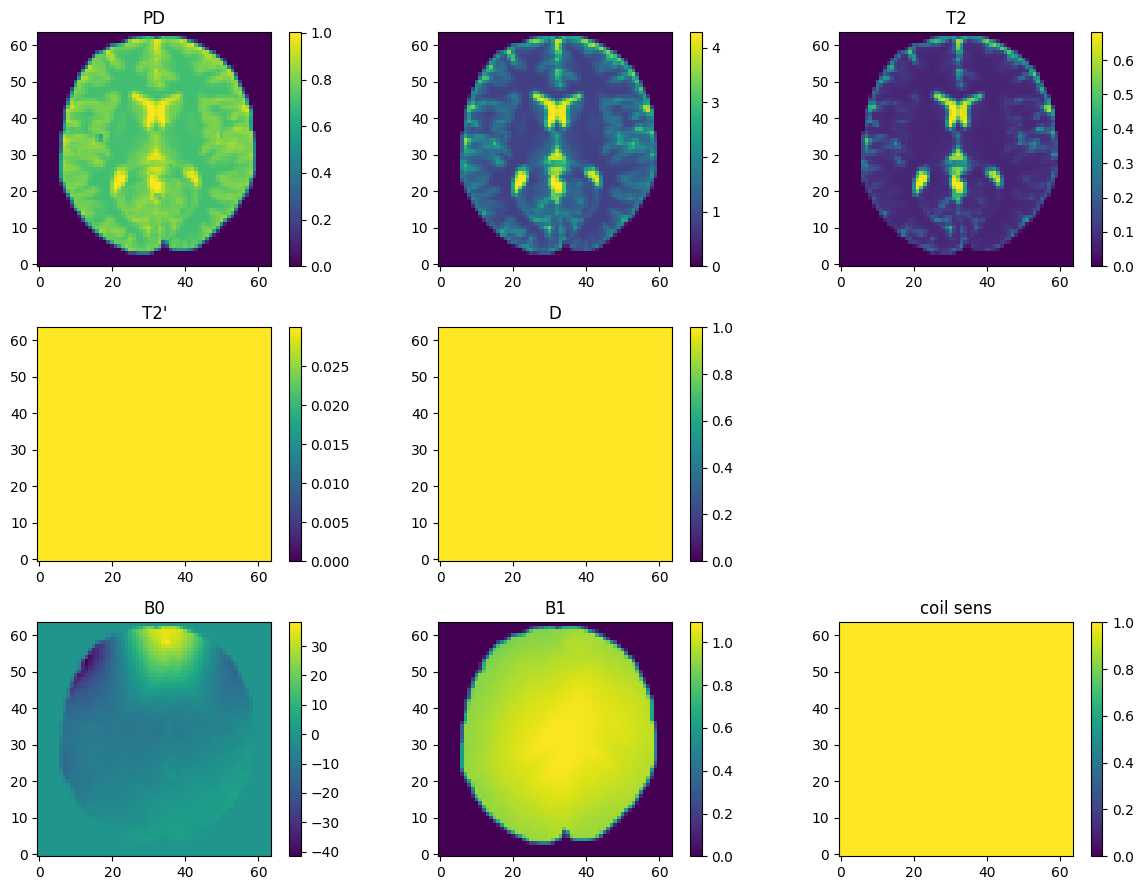

In [72]:
sz = [Nread, Nread]
os.chdir("/content")
phantom = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom = phantom.interpolate(sz[0], sz[1], 1)
# Convert Phantom into simulation data
obj_p = phantom.build()

phantom.plot()

**6. Load as MRzero sequence object and simulate signal acquisition**

Calculating repetition 1 / 1 - done


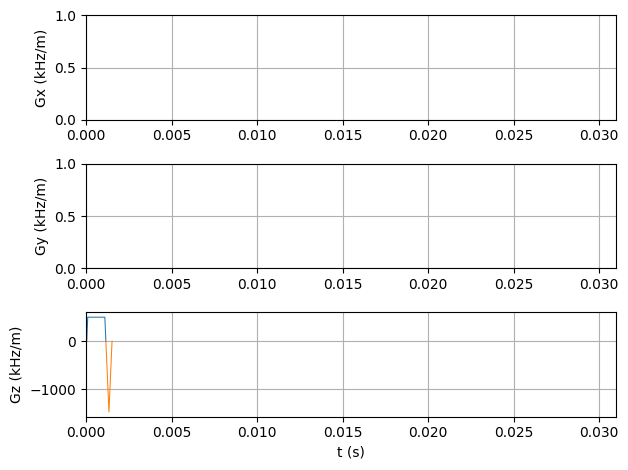

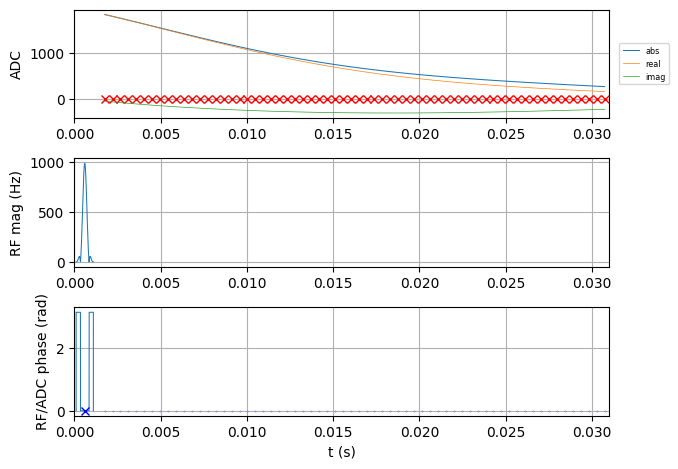

In [73]:
# T2* relaxation
seq0_T2star = mr0.Sequence.import_file('FID.seq')
graph_T2star = mr0.compute_graph(seq0_T2star, obj_p, 200, 1e-3)
signal_T2star = mr0.execute_graph(graph_T2star, seq0_T2star, obj_p)
seqT2star.plot(plot_now = False)
mr0.util.insert_signal_plot(seqT2star, signal_T2star.numpy())

Calculating repetition 2 / 2 - done


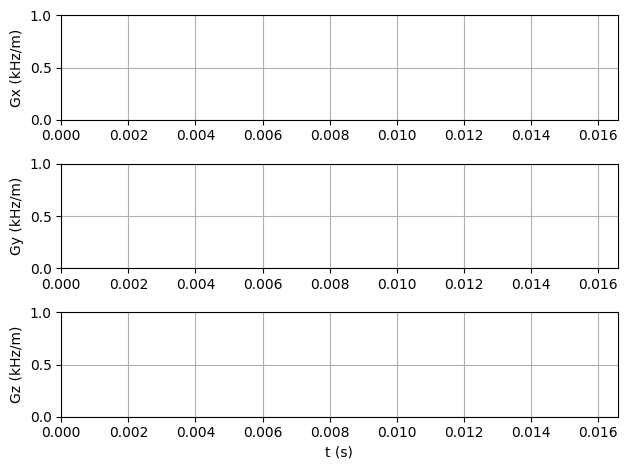

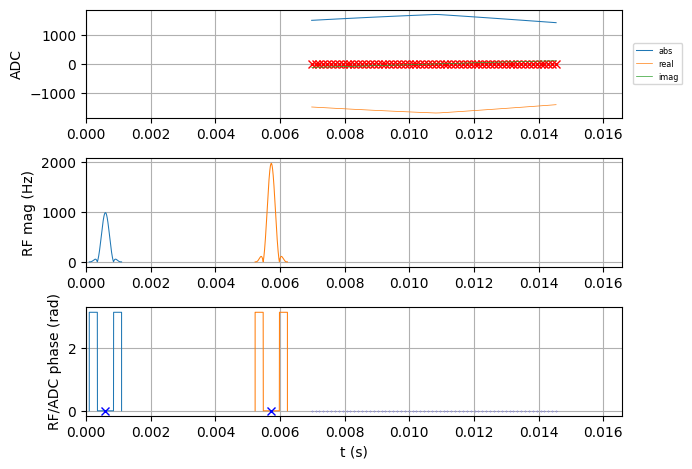

In [74]:
# Spin echo
seq0_T1 = mr0.Sequence.import_file('SpinEcho.seq')
graph_T1 = mr0.compute_graph(seq0_T1, obj_p, 200, 1e-3)
signal_T1 = mr0.execute_graph(graph_T1, seq0_T1, obj_p)
seqSE.plot(plot_now = False)
mr0.util.insert_signal_plot(seqSE, signal_T1.numpy())